In [1]:
import pandas as pd
import os
from glob import glob
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

### csv 불러와서 DataFrame 에 넣기

In [2]:
data_root_path = './data'
data_folders = glob(data_root_path + '/*')
merge_df = pd.DataFrame()

for data_folder in tqdm(data_folders) :
    data_csvs = glob(data_folder + '/*.csv')
    
    for data_csv in data_csvs :
        df = pd.read_csv(data_csv).rename(columns={"Unnamed: 0":'date'})
        merge_df = pd.concat([merge_df, df], ignore_index=True)

merge_df        

100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:26<00:00,  1.90it/s]


,date,open,high,low,close,volume,value
0,2017-09-25 12:00:00,4201000.0,4241000.0,4195000.0,4227000.0,15.940028,6.722878e+07
1,2017-09-25 12:10:00,4215000.0,4244000.0,4210000.0,4227000.0,16.224769,6.854317e+07
2,2017-09-25 12:20:00,4215000.0,4242000.0,4191000.0,4221000.0,16.144995,6.806705e+07
3,2017-09-25 12:30:00,4219000.0,4242000.0,4202000.0,4242000.0,17.943481,7.572972e+07
4,2017-09-25 12:40:00,4227000.0,4233000.0,4199000.0,4224000.0,19.122032,8.065820e+07
...,...,...,...,...,...,...,...
215598,2021-10-31 23:10:00,72015000.0,72201000.0,71950000.0,72195000.0,63.488926,4.572245e+09
215599,2021-10-31 23:20:00,72196000.0,72240000.0,72151000.0,72200000.0,56.652736,4.090660e+09
215600,2021-10-31 23:30:00,72220000.0,72350000.0,72077000.0,72215000.0,55.059246,3.976178e+09
215601,2021-10-31 23:40:00,72215000.0,72238000.0,71909000.0,72120000.0,53.188793,3.831516e+09


### date, value 제거

In [3]:
drop_columns = ['date', 'value']

dropped_merge_df = merge_df.drop(columns=drop_columns)
dropped_merge_df

,open,high,low,close,volume
0,4201000.0,4241000.0,4195000.0,4227000.0,15.940028
1,4215000.0,4244000.0,4210000.0,4227000.0,16.224769
2,4215000.0,4242000.0,4191000.0,4221000.0,16.144995
3,4219000.0,4242000.0,4202000.0,4242000.0,17.943481
4,4227000.0,4233000.0,4199000.0,4224000.0,19.122032
...,...,...,...,...,...
215598,72015000.0,72201000.0,71950000.0,72195000.0,63.488926
215599,72196000.0,72240000.0,72151000.0,72200000.0,56.652736
215600,72220000.0,72350000.0,72077000.0,72215000.0,55.059246
215601,72215000.0,72238000.0,71909000.0,72120000.0,53.188793


###  average price 구해서 feature 추가

In [4]:
dropped_merge_df['avg_price'] = (dropped_merge_df['high'] + 
                                 dropped_merge_df['low'] + 
                                dropped_merge_df['open'] + 
                                dropped_merge_df['close'] ) // 4
dropped_merge_df

,open,high,low,close,volume,avg_price
0,4201000.0,4241000.0,4195000.0,4227000.0,15.940028,4216000.0
1,4215000.0,4244000.0,4210000.0,4227000.0,16.224769,4224000.0
2,4215000.0,4242000.0,4191000.0,4221000.0,16.144995,4217250.0
3,4219000.0,4242000.0,4202000.0,4242000.0,17.943481,4226250.0
4,4227000.0,4233000.0,4199000.0,4224000.0,19.122032,4220750.0
...,...,...,...,...,...,...
215598,72015000.0,72201000.0,71950000.0,72195000.0,63.488926,72090250.0
215599,72196000.0,72240000.0,72151000.0,72200000.0,56.652736,72196750.0
215600,72220000.0,72350000.0,72077000.0,72215000.0,55.059246,72215500.0
215601,72215000.0,72238000.0,71909000.0,72120000.0,53.188793,72120500.0


### 10분 뒤 가격을 feature 추가
- close 기준
- target(label)이 될 예정
- 마지막 1행은 after10이 없으므로 삭제

In [5]:
after10 = np.zeros_like(dropped_merge_df['close'])
for i in range(len(dropped_merge_df['close']) - 1) :
        after10[i] = dropped_merge_df['close'][i + 1]
        
dropped_merge_df['after10'] = after10
dropped_merge_df = dropped_merge_df.drop([dropped_merge_df.index[-1]])
dropped_merge_df

,open,high,low,close,volume,avg_price,after10
0,4201000.0,4241000.0,4195000.0,4227000.0,15.940028,4216000.0,4227000.0
1,4215000.0,4244000.0,4210000.0,4227000.0,16.224769,4224000.0,4221000.0
2,4215000.0,4242000.0,4191000.0,4221000.0,16.144995,4217250.0,4242000.0
3,4219000.0,4242000.0,4202000.0,4242000.0,17.943481,4226250.0,4224000.0
4,4227000.0,4233000.0,4199000.0,4224000.0,19.122032,4220750.0,4202000.0
...,...,...,...,...,...,...,...
215597,72129000.0,72190000.0,72011000.0,72030000.0,41.220222,72090000.0,72195000.0
215598,72015000.0,72201000.0,71950000.0,72195000.0,63.488926,72090250.0,72200000.0
215599,72196000.0,72240000.0,72151000.0,72200000.0,56.652736,72196750.0,72215000.0
215600,72220000.0,72350000.0,72077000.0,72215000.0,55.059246,72215500.0,72120000.0


### Data normalization

In [6]:
norm = MinMaxScaler()
norm_np = norm.fit_transform(dropped_merge_df)
norm_df = pd.DataFrame(norm_np, columns=list(dropped_merge_df.columns))
norm_df

,open,high,low,close,volume,avg_price,after10
0,0.008039,0.008480,0.008098,0.008346,0.004478,0.008236,0.008346
1,0.008218,0.008518,0.008290,0.008346,0.004558,0.008339,0.008269
2,0.008218,0.008493,0.008047,0.008269,0.004535,0.008252,0.008538
3,0.008269,0.008493,0.008188,0.008538,0.005041,0.008367,0.008308
4,0.008371,0.008378,0.008149,0.008308,0.005372,0.008297,0.008027
...,...,...,...,...,...,...,...
215597,0.876217,0.874978,0.875676,0.874949,0.011579,0.875957,0.877058
215598,0.874760,0.875118,0.874896,0.877058,0.017835,0.875960,0.877122
215599,0.877074,0.875615,0.877467,0.877122,0.015915,0.877322,0.877313
215600,0.877380,0.877018,0.876521,0.877313,0.015467,0.877562,0.876099


### Data split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    norm_df.drop('after10', 1), 
    norm_df['after10'], 
    test_size=0.1, 
    random_state=0, 
    shuffle=False)

print(x_train.shape, y_train.shape)
print(x_train)
print(y_train)

(194041, 6) (194041,)
            open      high       low     close    volume  avg_price
0       0.008039  0.008480  0.008098  0.008346  0.004478   0.008236
1       0.008218  0.008518  0.008290  0.008346  0.004558   0.008339
2       0.008218  0.008493  0.008047  0.008269  0.004535   0.008252
3       0.008269  0.008493  0.008188  0.008538  0.005041   0.008367
4       0.008371  0.008378  0.008149  0.008308  0.005372   0.008297
...          ...       ...       ...       ...       ...        ...
194036  0.531569  0.530516  0.530863  0.530879  0.004195   0.531258
194037  0.531032  0.529789  0.530147  0.529716  0.003751   0.530471
194038  0.529600  0.529509  0.530096  0.530406  0.004223   0.530203
194039  0.530418  0.531600  0.529993  0.532477  0.013333   0.531424
194040  0.532042  0.531243  0.531183  0.531454  0.008351   0.531782

[194041 rows x 6 columns]
0         0.008346
1         0.008269
2         0.008538
3         0.008308
4         0.008027
            ...   
194036    0.529716
19

### Tensorflow Dataset 활용하여 시퀀스 데이터셋 구성
[출처:https://teddylee777.github.io/tensorflow/lstm-stock-forecast]

- window_size : 과거 몇 개의 데이터를 기준으로 다음에 오는 데이터를 예측할 것인가를 결정
    - 만약 window_size=6 이면, 6개(1시간 치 데이터)를 기준으로 다음에 10분 후에 나오는 데이터의 after10을 예측함

In [8]:
def windowed_dataset(data, label, window_size, batch_size, shuffle):

    ds_x = tf.data.Dataset.from_tensor_slices(data)
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))

    ds_y = tf.data.Dataset.from_tensor_slices(label[window_size:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)

WINDOW_SIZE = 6
BATCH_SIZE = 64

train_data = windowed_dataset(x_train, y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(x_test, y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [10]:
# for data in train_data.take(1):
#     print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
# #     print(data[0])
#     print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')
#     print(data[1])

for data in test_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(data[0])
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')
    print(data[1])

데이터셋(X) 구성(batch_size, window_size, feature갯수): (64, 6, 6)
tf.Tensor(
[[[0.53145369 0.53080925 0.53160541 0.53169734 0.00463816 0.53169226]
  [0.53170931 0.53123007 0.53182289 0.53199131 0.00694845 0.53198949]
  [0.53204161 0.53107705 0.53209155 0.5317229  0.00754738 0.53203424]
  [0.53196493 0.53100054 0.53209155 0.53201687 0.00719113 0.53206939]
  [0.53202883 0.53147237 0.53266724 0.53270706 0.00758885 0.53252004]
  [0.53268066 0.5328241  0.53323014 0.5338318  0.01267084 0.5334437 ]]

 [[0.53170931 0.53123007 0.53182289 0.53199131 0.00694845 0.53198949]
  [0.53204161 0.53107705 0.53209155 0.5317229  0.00754738 0.53203424]
  [0.53196493 0.53100054 0.53209155 0.53201687 0.00719113 0.53206939]
  [0.53202883 0.53147237 0.53266724 0.53270706 0.00758885 0.53252004]
  [0.53268066 0.5328241  0.53323014 0.5338318  0.01267084 0.5334437 ]
  [0.53395874 0.53313015 0.53421521 0.53399796 0.01727119 0.53412766]]

 [[0.53204161 0.53107705 0.53209155 0.5317229  0.00754738 0.53203424]
  [0.53196493 0.

### Model Define

In [51]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Input, GlobalAveragePooling1D
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [52]:
def get_model(input_shape):
    input = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True, activation='tanh', dropout=0.2)(input)
    x = LSTM(64, return_sequences=True, activation='tanh', dropout=0.2)(x)
    x = LSTM(32, return_sequences=True, activation='tanh', dropout=0.2)(x)
    x = GlobalAveragePooling1D()(x)
    output = Dense(1)(x)
    model = Model(input, output)
    return model

feature_n = 6
model = get_model((WINDOW_SIZE, feature_n))
model

# model = Sequential([
#     # 1차원 feature map 생성
#     Conv1D(filters=32, kernel_size=5,
#            padding="causal",
#            activation="relu",
#            input_shape=[WINDOW_SIZE, 1]),
#     # LSTM
#     LSTM(16, activation='tanh'),
#     Dense(16, activation="relu"),
#     Dense(1),
# ])

### model compile

In [53]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

earlystopping = EarlyStopping(monitor='val_loss', patience=40)

filename = os.path.join('./checkpoints', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

### Train

In [54]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=100, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/100
3028/3028 [==============================] - 26s 7ms/step - loss: 5.4369e-05 - mse: 1.0874e-04 - val_loss: 0.0013 - val_mse: 0.0025

Epoch 00001: val_loss improved from inf to 0.00125, saving model to ./checkpoints\ckeckpointer.ckpt
Epoch 2/100
3028/3028 [==============================] - 22s 7ms/step - loss: 1.9166e-04 - mse: 3.8332e-04 - val_loss: 0.0056 - val_mse: 0.0111

Epoch 00002: val_loss did not improve from 0.00125
Epoch 3/100
3028/3028 [==============================] - 23s 8ms/step - loss: 1.8292e-04 - mse: 3.6583e-04 - val_loss: 0.0082 - val_mse: 0.0165

Epoch 00003: val_loss did not improve from 0.00125
Epoch 4/100
3028/3028 [==============================] - 23s 8ms/step - loss: 1.5744e-04 - mse: 3.1488e-04 - val_loss: 0.0080 - val_mse: 0.0161

Epoch 00004: val_loss did not improve from 0.00125
Epoch 5/100
3028/3028 [==============================] - 23s 7ms/step - loss: 1.0889e-04 - mse: 2.1778e-04 - val_loss: 0.0091 - val_mse: 0.0182

Epoch 00005: val_loss 

In [55]:
history

In [56]:
model.load_weights(filename)
pred = model.predict(test_data)
actual = np.asarray(y_test)[WINDOW_SIZE:]
actual = np.reshape(actual, (len(actual), 1))
print(pred.shape)
print(actual.shape)


(21522, 1)
(21522, 1)


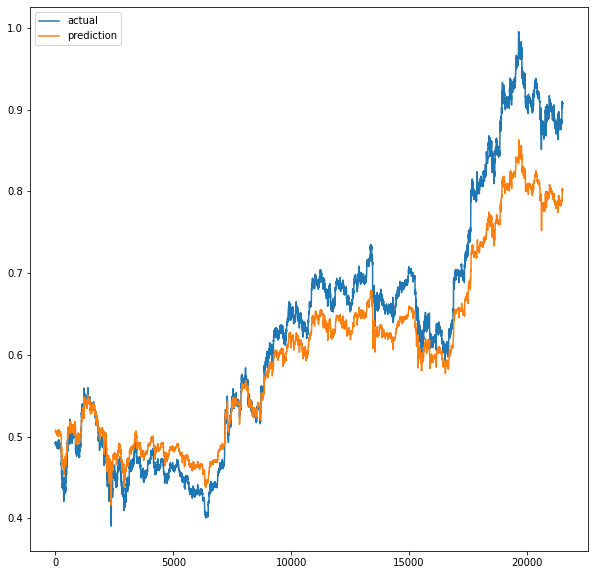

In [57]:
plt.figure(figsize=(10,10))
plt.plot(actual, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()